In [3]:
import base64
from pathlib import Path
from multiprocessing import Pool
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import regex
from wordcloud import WordCloud

## Convert binary to text, and classify language

In [4]:
type RANK = str
type LANG_CODE = str
type TEXT = str
type CHAR_RANKS = list[TEXT, LANG_CODE, RANK]

In [5]:
# Unicode code ranges for various language
CODE_RANGES = {
    "en": (("\u0041", "\u005A"), ("\u0061", "\u007A")),
    "th": (("\u0E00", "\u0E7F"), ),
    "jp": (
        ("\u3000", "\u303F"), ("\u3040", "\u309F"), ("\u30A0", "\u30FF"), 
        ("\u31F0", "\u31FF"), ("\u4E00", "\u9FAF"), ("\uFF5F", "\uFF9F"), 
        ("\u2E80", "\u2FD5"), ("\u3220", "\u3243"), ("\u3280", "\u337F"),
    ),
}

In [6]:
bpes = (Path("data") / "cl100k_base.tiktoken").read_text().splitlines()

bpes_mapping = { 
    rank: base64.b64decode(token).decode("utf-8", "replace")
    for token, rank in (line.split() for line in bpes if line)
}

In [7]:
def detect_lang(c: str, rangess: dict[str, tuple[tuple[str, str]]]=CODE_RANGES) -> str:
    for lang,  ranges in rangess.items():
        for _range in ranges:
            if _range[0] <= c <= _range[1]:
                return lang
    
    return "UNK"


def extract_line(pair) -> tuple[str, str, str]:
    rank, text = pair
    commons = Counter([detect_lang(c) for c in text]).most_common(1)

    lang = commons[0][0]

    return text, lang, rank

def get_tokens_from_lang(lang: str, char_ranks: CHAR_RANKS) -> list[str]: 
    return list(filter(lambda t: t[1] == lang, char_ranks))

def get_num_tokens_from_lang(lang: str, char_ranks: CHAR_RANKS) -> int:
    return len(get_tokens_from_lang(lang, char_ranks))


def get_summary_table(char_ranks: CHAR_RANKS, rangess: dict[str, tuple[tuple[str, str]]]=CODE_RANGES) -> pd.DataFrame:
    output = []
    for lang in rangess.keys():
        tokens = get_tokens_from_lang(lang, char_ranks)
        size = len(tokens)
        sampling = "  ".join(pd.DataFrame(tokens).sample(min(10, size), random_state=987).iloc[:, 0].to_list())
        output.append((lang, size, sampling))

    return pd\
        .DataFrame(output, columns=["lang", "size", "sampling"])\
        .assign(percent_ratio=lambda x: (x["size"] / len(char_ranks) *100).round(4))

In [8]:
with Pool(8) as pool:
    char_ranks = list(pool.map(extract_line, list(bpes_mapping.items())))

In [9]:
summary_df = get_summary_table(char_ranks)
token_df = pd.DataFrame(char_ranks, columns=["token", "language", "rank"])

In [10]:
summary_df.head()

,lang,size,sampling,percent_ratio
0,en,88191,meal pcb proficient Wohn syn zo Ma...,87.9658
1,th,57,ั ร ไม ต ้ ง ื่ ท ื ล,0.0569
2,jp,985,描述 県 キ 藏 最 后 作 第 设置 结,0.9825


In [11]:
# Save summary to output dir
token_df.to_csv(Path("output") / "cl100k_base.text.csv", index=False)
summary_df.to_csv(Path("output") / "cl100k_base.token_summary.csv", index=False)

## Word cloud for language

In [12]:
def generate_wordcloud_img(lang_token: dict[TEXT, RANK], **kwargs) -> WordCloud:
    return WordCloud(**kwargs).generate_from_frequencies(lang_token)

In [13]:
get_frequencies = lambda lang: {regex.sub(r"\s+", " ", t[0]): int(t[2]) for t in get_tokens_from_lang(lang, char_ranks)}
en_token = get_frequencies("en")
th_token = get_frequencies("th")
jp_token = get_frequencies("jp")

In [14]:
en_wordcloud = generate_wordcloud_img(en_token, relative_scaling=1, max_words=500, margin=2, min_font_size=3, collocations=False)
th_wordcloud = generate_wordcloud_img(th_token, font_path=Path("fonts") / "THSarabunNew.ttf", relative_scaling=1, max_words=500, margin=2, min_font_size=3, collocations=False)
jp_wordcloud = generate_wordcloud_img(jp_token, font_path=Path("fonts") / "MochiyPopPOne-Regular.ttf", relative_scaling=1, max_words=500, margin=2, min_font_size=3, collocations=False)

### English wordcloud

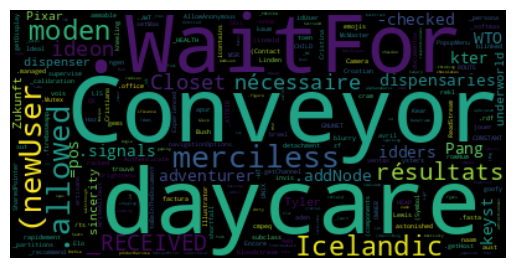

In [15]:
# Display the generated image:
plt.imshow(en_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Thai wordcloud

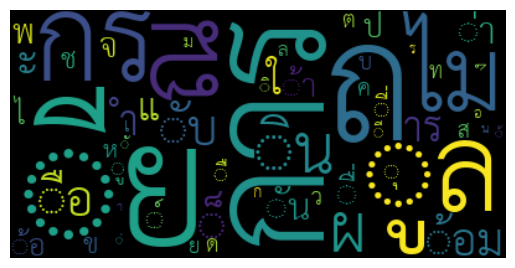

In [16]:
# Display the generated image:
plt.imshow(th_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Japanese wordcloud

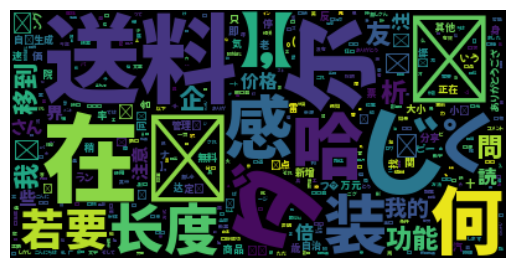

In [17]:
# Display the generated image:
plt.imshow(jp_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()